In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import perf_counter
from pathlib import Path
from IPython.display import Image, display, Markdown

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import seaborn as sns

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
imageDir = Path('Diabetic Retinography Images/')

filepaths = list(imageDir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
1,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
2,../input/diabetic-retinopathy-224x224-gaussian...,Moderate
3,../input/diabetic-retinopathy-224x224-gaussian...,Mild
4,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
...,...,...
3657,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
3658,../input/diabetic-retinopathy-224x224-gaussian...,Moderate
3659,../input/diabetic-retinopathy-224x224-gaussian...,Mild
3660,../input/diabetic-retinopathy-224x224-gaussian...,Mild


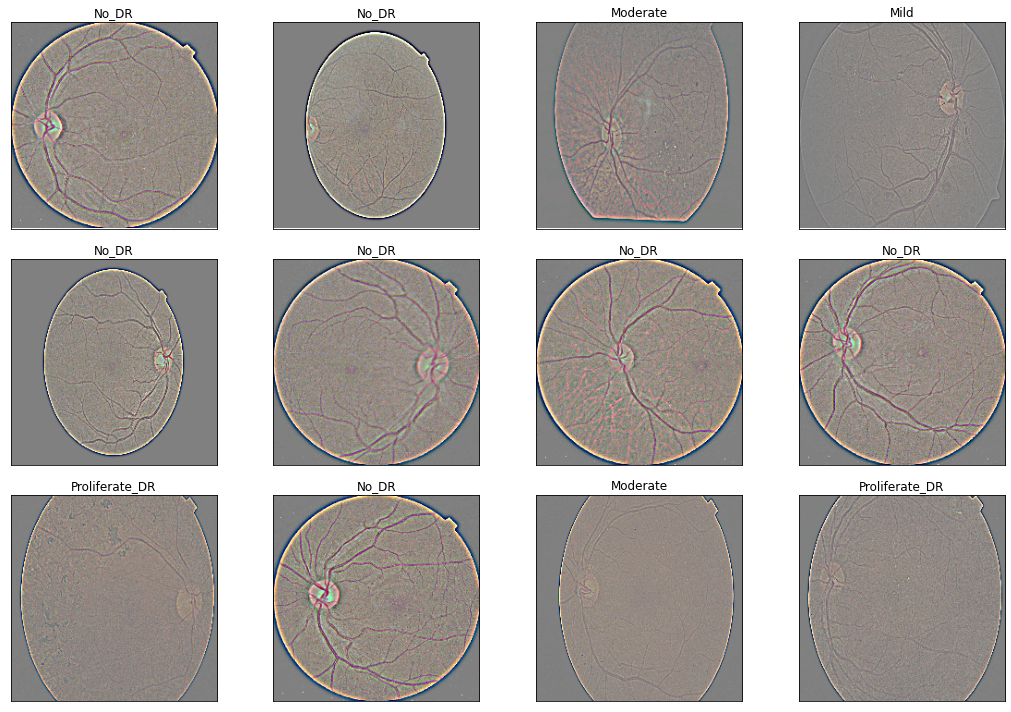

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.show()

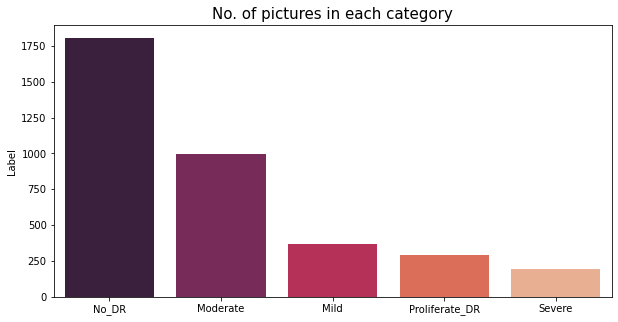

In [6]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("No. of pictures in each category", fontsize=15)
plt.show()

In [7]:
def createGen():
    trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    trainImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    testImages = testGen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return trainGen, testGen, trainImages, valImages, testImages

In [8]:
def getModel(model):
    kwargs = {
        'input_shape':(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'avg'
    }
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [11]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

for name, model in models.items():
    X = getModel(model['model'])
    models[name]['model'] = X
    
    start = perf_counter()
    history = X.fit(trainImages, validation_data=valImages, epochs=10)
    
    duration = round((perf_counter() - start), 2)
    models[name]['perf'] = duration
    print(f"{name:20} -> trained in -> {duration} Sec")
    
    valAcc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in valAcc]
    
    trainAcc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in trainAcc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


2022-09-28 16:19:13.297997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 16:19:13.391435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 16:19:13.392224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 16:19:13.394065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


2022-09-28 16:19:19.399920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-28 16:19:26.484871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 64s 560ms/step - loss: 0.8364 - accuracy: 0.7053 - val_loss: 0.7194 - val_accuracy: 0.7386
Epoch 2/10
93/93 [==============================] - 15s 164ms/step - loss: 0.6534 - accuracy: 0.7549 - val_loss: 0.6802 - val_accuracy: 0.7568
Epoch 3/10
93/93 [==============================] - 18s 193ms/step - loss: 0.6250 - accuracy: 0.7711 - val_loss: 0.7484 - val_accuracy: 0.7082
Epoch 4/10
93/93 [==============================] - 16s 167ms/step - loss: 0.5870 - accuracy: 0.7795 - val_loss: 0.6494 - val_accuracy: 0.7660
Epoch 5/10
93/93 [==============================] - 15s 158ms/step - loss: 0.5509 - accuracy: 0.7889 - val_loss: 0.6359 - val_accuracy: 0.7568
Epoch 6/10
93/93 [==============================] - 13s 135ms/step - loss: 0.5481 - accuracy: 0.7920 - val_loss: 0.6287 - val_accuracy: 0.7599
Epoch 7/10
93/93 [==============================] - 12s 133ms/step - loss: 0.5432 - accuracy: 0.7964 - val_loss: 0.6961 - val_accuracy: 0.7629
Epoch 8/10

In [22]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [23]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 18s 162ms/step - loss: 0.7808 - accuracy: 0.7266 - val_loss: 0.7137 - val_accuracy: 0.7508
Epoch 2/10
93/93 [==============================] - 11s 118ms/step - loss: 0.6264 - accuracy: 0.7653 - val_loss: 0.7099 - val_accuracy: 0.7508
Epoch 3/10
93/93 [==============================] - 12s 129ms/step - loss: 0.5843 - accuracy: 0.7859 - val_loss: 0.6573 - val_accuracy: 0.7477
Epoch 4/10
93/93 [==============================] - 12s 125ms/step - loss: 0.5375 - accuracy: 0.7984 - val_loss: 0.6807 - val_accuracy: 0.7720
Epoch 5/10
93/93 [==============================] - 11s 120ms/step - loss: 0.4961 - accuracy: 0.8149 - val_loss: 0.6903 - val_accuracy: 0.7508


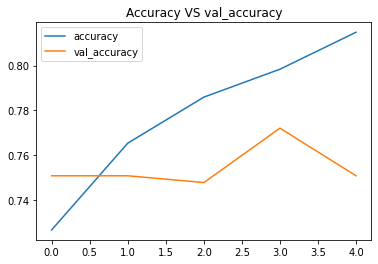

In [24]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy VS val_accuracy")
plt.show()

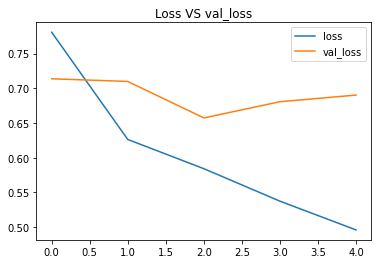

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss VS val_loss")
plt.show()

In [31]:
results = model.evaluate(testImages, verbose=0)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

> ## Test Loss |> 0.60498

> ## Accuracy |> 79.02%

In [33]:
pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]

print(f'The first 10 predictions:\n{pred[:10]}')

The first 10 predictions:
['Moderate', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'Mild', 'Moderate', 'Moderate', 'No_DR', 'Proliferate_DR']


In [36]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.67      0.74      0.70        38
      Moderate       0.61      0.82      0.70        88
         No_DR       0.94      0.96      0.95       184
Proliferate_DR       0.79      0.28      0.41        40
        Severe       0.50      0.18      0.26        17

      accuracy                           0.79       367
     macro avg       0.70      0.59      0.60       367
  weighted avg       0.80      0.79      0.77       367



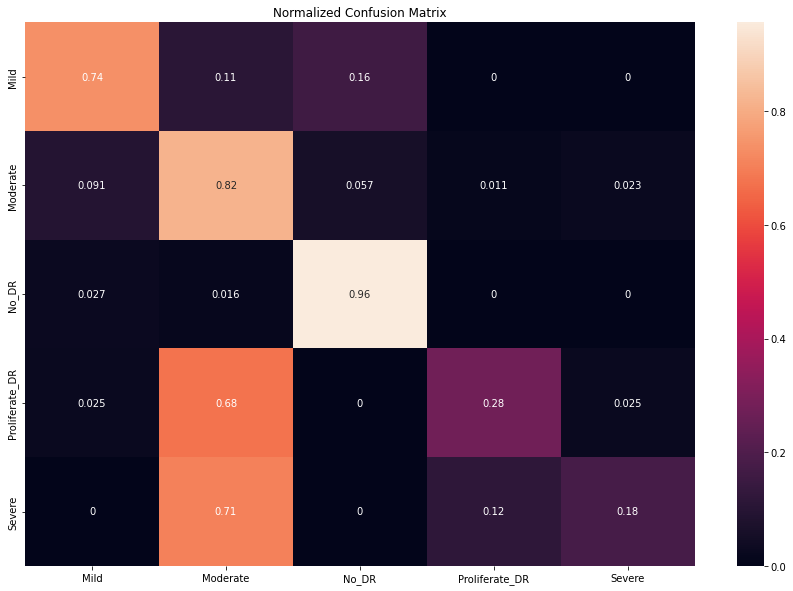

In [37]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15, 10))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

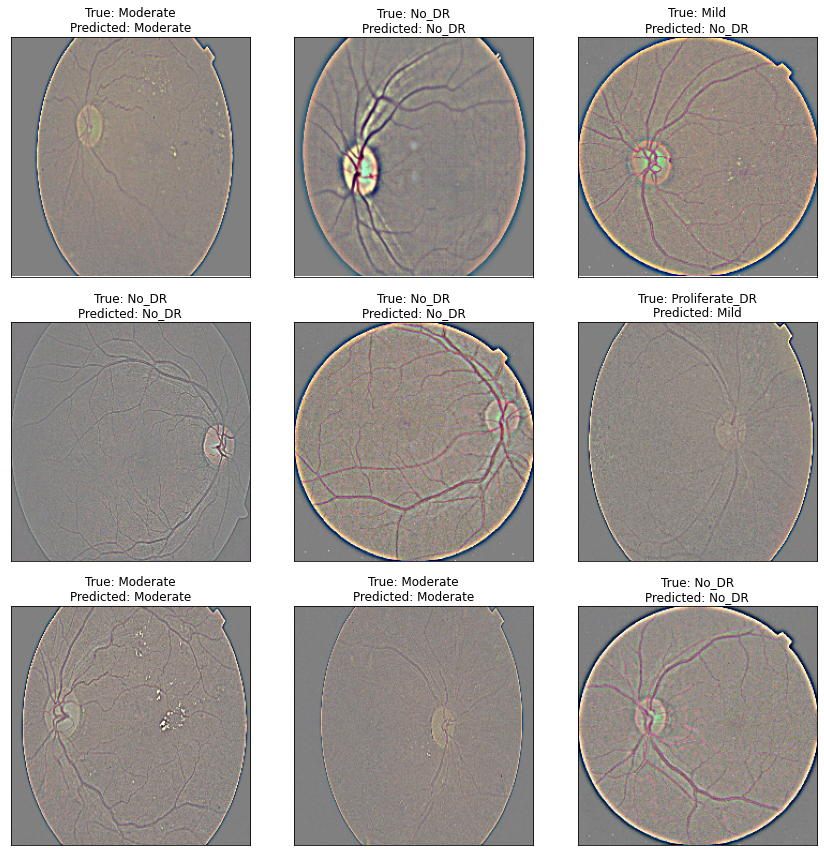

In [41]:
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 12),
    subplot_kw={'xticks':[], 'yticks':[]}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')

plt.tight_layout()
plt.show()

In [46]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224, 224)

model.layers[-1].activation = None

In [48]:
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x=='No_DR' else 'DR')
image_df_red

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
1,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
2,../input/diabetic-retinopathy-224x224-gaussian...,DR
3,../input/diabetic-retinopathy-224x224-gaussian...,DR
4,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
...,...,...
3657,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
3658,../input/diabetic-retinopathy-224x224-gaussian...,DR
3659,../input/diabetic-retinopathy-224x224-gaussian...,DR
3660,../input/diabetic-retinopathy-224x224-gaussian...,DR


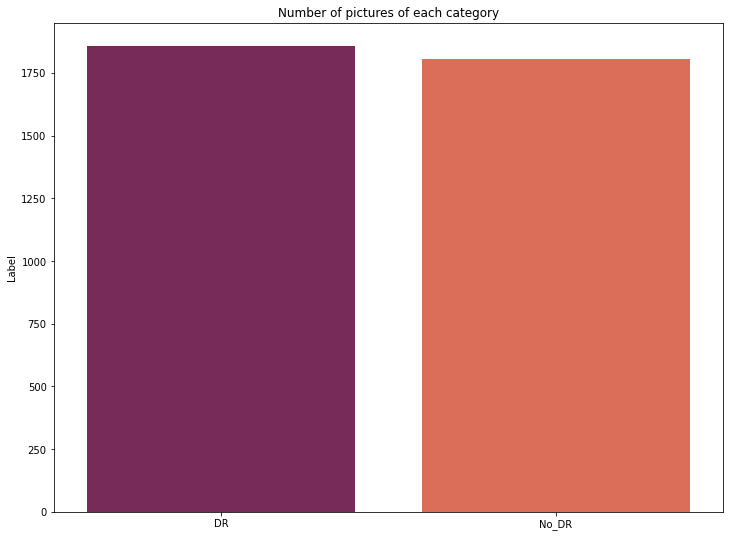

In [53]:
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(12, 9))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=12)
plt.show()

In [54]:
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [55]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 15s 136ms/step - loss: 0.1937 - accuracy: 0.9316 - val_loss: 0.2548 - val_accuracy: 0.9119
Epoch 2/10
93/93 [==============================] - 11s 119ms/step - loss: 0.1303 - accuracy: 0.9568 - val_loss: 0.1813 - val_accuracy: 0.9483
Epoch 3/10
93/93 [==============================] - 11s 122ms/step - loss: 0.1114 - accuracy: 0.9629 - val_loss: 0.1527 - val_accuracy: 0.9544
Epoch 4/10
93/93 [==============================] - 12s 125ms/step - loss: 0.0951 - accuracy: 0.9693 - val_loss: 0.1994 - val_accuracy: 0.9483
Epoch 5/10
93/93 [==============================] - 11s 121ms/step - loss: 0.1070 - accuracy: 0.9659 - val_loss: 0.1550 - val_accuracy: 0.9544
Epoch 6/10
93/93 [==============================] - 12s 126ms/step - loss: 0.0808 - accuracy: 0.9717 - v

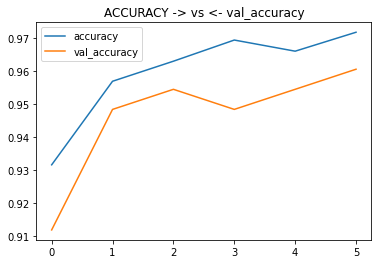

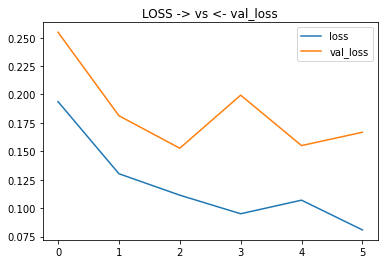

12/12 [==============================] - 1s 105ms/step - loss: 0.1298 - accuracy: 0.9482


> ## Test Loss |> 0.12976

> ## Accuracy |> 94.82%



The first 10 predictions:
 ['DR', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'DR', 'DR', 'DR', 'No_DR', 'DR']


               precision    recall  f1-score   support

          DR       0.95      0.95      0.95       183
       No_DR       0.95      0.95      0.95       184

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



In [64]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("ACCURACY -> vs <- val_accuracy")
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("LOSS -> vs <- val_loss")
plt.show()

results = model.evaluate(testImages)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]
print(f'\n\nThe first 10 predictions:\n {pred[:10]}')

y_test = list(test_df.Label)
print(f'\n\n {classification_report(y_test, pred)}')

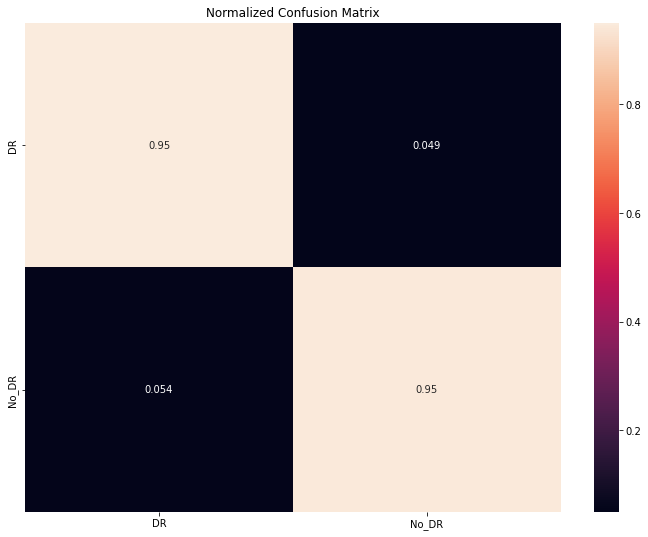

In [67]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (12, 9))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()